In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

import util_compatibility

%matplotlib inline

pd.set_option('max_colwidth', None)

# Classifying Rakuten Product Categories

__Goal__ Determine whether it is viable to automatically classify product descriptions into their Rakuten categories

__Summary__ At a high-level, it will likely be possible (with further work) to automatically classify the majority of product descriptions. There are a few important caveats. Some categories, namely common catagories that are well-represented in the data, are more amenable to prediction than other categories. For example, categories `3730`, `4238`, `92`, `3625`, `2199`, `1608`, and `4015` are all predicted correctly over half of the time, and so will need verification less than other categories. Luckily, poor prediction is clustered around a few predicted labels. In addition, the prediction quality may deteriorate the deeper into categorization we go (that is, the first level of categorization will likely be more accurate than the next level). Deeper levels are less well-represented in the data.


In [2]:
rktn_train_url = (
    "https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv"
)
rktn_test_url = (
    "https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv"
)

rktn_train_df = pd.read_csv(rktn_train_url, delimiter="\t", header=None)
rktn_test_df = pd.read_csv(rktn_test_url, delimiter="\t")

# The original training data does not have column names; I've pulled them from the test set
rktn_train_df.columns = rktn_test_df.columns[:]

In [3]:
# common test and train sets
train_X, train_y = util_compatibility.load_standard_x_y(rktn_train_df)
test_X, test_y = util_compatibility.load_standard_x_y(rktn_test_df)

## EDA 

For the sake of time, I'm going to restrict myself only to the first category level, noting that given more time, I could also consider additional category levels. I decided to do this in order to reduce the amount of error.

In order to understand the data, I want to understand:
1. How balanced is the target? This will help me understand what evaluation metric to give most weight to. For example, given a well-balanced target, I could use accuracy as an effective metric. Without balance, I will need to evaluate with more nuance
2. What does my data look like? This takes many forms, but for the purposes of this exercise, I'm interested in better understanding how distributed top words are among each category, as well as take a look at a few sample titles. This is largely so that I have a better sense of how to move forward with the modeling

In the interest of keeping this analysis tight, I've moved beginning analysis to the bottom of this notebook.

### How balanced is the target?

It seems like the target categories are not particularly well-balanced. In fact, the top 4 categories represent about half of all products. There are some categories that represent under 1% of all products (like 1208). I'll keep this in mind for additional analysis 

In [4]:
category_1_count = rktn_train_df["category_level_0"].value_counts(ascending=False)
category_1_count.reset_index().rename(
    columns={"index": "category_level_0", "category_level_0": "count"}
)

,category_level_0,count
0,4015,268295
1,3292,200945
2,2199,96714
3,1608,85554
4,3625,29557
5,2296,28412
6,4238,23529
7,2075,20086
8,1395,18847
9,92,8172


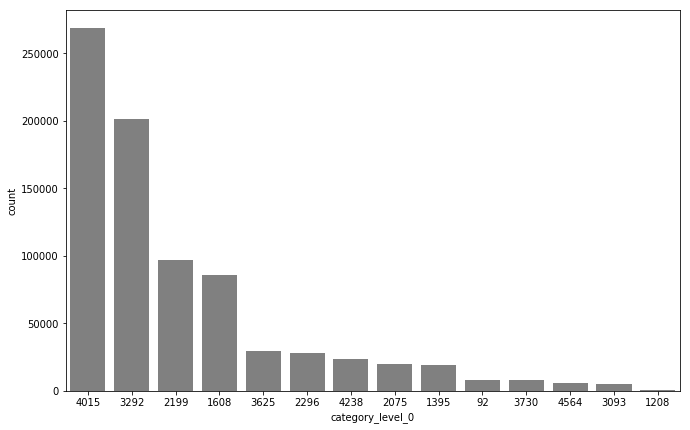

In [5]:
plt.figure(figsize=(11, 7))
sns.countplot(
    rktn_train_df["category_level_0"], order=category_1_count.index, color="gray"
)
plt.show()

### What does the data look like?

The purpose of this question is to get a better feel of the data. I address this question in a few steps. 
1. Looking at a few sample products
2. Looking at a few common words 

Because this data necessarily involves constructing features from text, and I would like to have as simple features as possible (and eventually, as simple of a model as possible) for the first attempt at the assignment, I'd like to look at a few sample product titles to get a good sense of how I should approach creating features. For example, if the product descriptions were long and involved, perhaps I'd want to preserve directional relationships between words. 

In [6]:
np.random.seed(2020)
rktn_train_df.sample(10)[["Title", "CategoryIdPath"]]

,Title,CategoryIdPath
520684,Canon EOS 6D 20.1 MP Digital SLR Camera (Body) plus 32GB Accessory Kit,3292>1041>4175>1077>1242
594994,"ACCUFORM SIGNS MEQM340VS Warning Sign, 10 x 14In, BK/ORN, ENG, Text",4015>2028>3840
603078,4.9mm Drilling Dia HSS Cobalt Metric Spiral Twist Drill Bit Rotary Tool 6pcs,4015>3754>3663>512>4157>2564
750199,Mitsubishi VLT-HC3LP Projector Housing with Genuine Original OEM Bulb,3292>290>497
798258,Buy Enlarge 0-587-26574-4C12X18 Kakitsubata - Iris Laevigata in a Tsubo- Canvas Size C12X18,4015>4245>2682
635826,"Victor Muffler Saddle Camp 1-7/8"" 13 Ga. Steel",4015>2028>2159
651082,ReadyLift 69-8000 SST Lift Kit Fits 06-10 Ridgeline,2199>4592>12
433456,"KIPP 06460-1A21X30 Adj Handle, MD, 1/4-20, Ext, 1.18, 1.85",4015>3754>3580>31
384733,Lo Mas Lejos A Tu Lado,2296>3597>2002
686252,Max Roach Live In Berlin,2296>3597>2093


The descriptions here are quite sparse. Indeed, they contain some product-specific lingo and a lot of things that I don't immediately understand. For example, I don't really understand the entire entry, `KIPP 06460-1A21X30 Adj Handle, MD, 1/4-20, Ext, 1.18, 1.85`. On the other hand, it seems like this text is sufficiently simple to use bag-of-words or TF/IDF for feature generation.  

To get a better sense of how this will look, I'll first take a BOW with a few additions: (not shown) I'll stem the words (I want `Live` and `Living` to be the same for now), (shown) I'll remove the number-only "words", (shown) and I'll restrict myself to the top 20 or so words by count. Note that the stemming doesn't come default with `sklearn`'s text feature extraction tools; it requires `nltk` and so is removed from this version. 

In [7]:
eda_vectorizer = CountVectorizer(
    max_features=20, token_pattern=u"(?ui)\\b\\w*[a-z]+\\w*\\b"
)

In [8]:
eda_vectorizer_output = eda_vectorizer.fit_transform(rktn_train_df["Title"]).toarray()
eda_vectorizer_output_df = pd.DataFrame(eda_vectorizer_output)
eda_vectorizer_output_df.columns = eda_vectorizer.get_feature_names()
eda_vectorizer_output_df = eda_vectorizer_output_df.assign(
    original_text=rktn_train_df["Title"], category=rktn_train_df["category_level_0"]
)

In [9]:
top_word_means = eda_vectorizer_output_df.groupby("category").mean()
top_word_means.idxmax()

and            3292
battery        3292
black          3093
cover          3292
decal          3292
filter         4015
for            3292
in             3093
mightyskins    3292
pack           1208
protective     3292
replacement    4015
s              1608
silver         1608
skin             92
vinyl          3292
white          1608
with           2075
wrap           3292
x              4238
dtype: int64

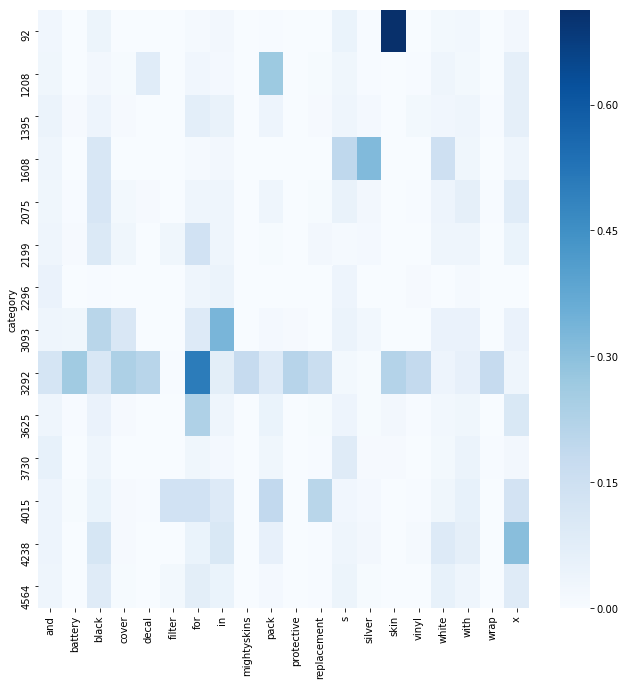

In [10]:
plt.figure(figsize=(11, 11))
sns.heatmap(top_word_means, cmap="Blues")
plt.show()

## Training model

At this point, the EDA suggests to me that BOW and TF-IDF are likely good feature creation strategies -- I don't need something more complex. I'm also interested in using the simplest and most explainable classifier possible; analysis in the last section of this notebook suggests that perhaps a decision tree would be too simple, but a neural net would be unecessary. I'm going to use`MultinomialNB`, a go-to standard for texty stuff. In the appendix, I'll also describe how I would verify with a `Gradient Boosting Classifier`, which is my favorite all-purpose classifier. 

### Potential baselines

Before I do, though - I want to get a sense of what my performance metrics would look like if I simply randomly assigned all labels in the proportions they occur in the data to the dataset as a potential baseline. I already know that if I assigned all products to category `4015`, I'd be right about 33.5% of the time, and so I'm looking for a second datapoint. I also want to look at `balanced accuracy` because I know my sample is imbalanced (average recall by class). Note that the `sklearn` implementation is equivalent to the class-weighted accuracy score.  

In [11]:
y_all_4015 = np.full(fill_value=4015, shape=rktn_train_df.shape[0])
balanced_accuracy_score(train_y, y_all_4015)
accuracy_score(train_y, y_all_4015)

0.33536875

In [12]:
y_permutation = rktn_train_df["category_level_0"].sample(rktn_train_df.shape[0])
balanced_accuracy_score(train_y, y_permutation)
accuracy_score(train_y, y_permutation)

0.206985

### Building a model

I'm not super concerned about which type of model is best yet -- feature development and modeling are not yet refined enough for small differences between models to make a big difference. But, I'm going to try a few different things:
1. `MultinomialNB` with:
    - `BOW` without stemming
    - `TF/IDF` without stemming (and depending on the result, with)
    
*Note that stemming takes a while to do (I don't write code as clean as `sklearn` developers), and so absent significant benefits, I won't use it for this round of analysis.

In [13]:
cv = CountVectorizer()
dictionary = cv.fit(train_X)
len(dictionary.vocabulary_)

427297

### A note on feature generation

The vocubulary for this is very large and quite sparse (see above). Because it's relatively sparse, I wanted to investigate an analytical way to reduce the dimensionality of the data (and evaluated that first). For ease of use, I chose to first evaluate using TruncatedSVD. I also compared this to a less-nuanced dimensionality reduction strategy -- taking the top 1200 words.  

A few notes here:
  1. I'd like to reduce the number of features as much as possible so that I don't *overfit* my model. My dictionary, given infinite features, is over 400,000 words long, and there are 800,000 training records, so 12,000 features seems reasonable to me as a rough yardstick assumption. One way to refine this for the future would be to use a more nuanced dimensionality reduction strategy, like SVD or PCA; these are time intensive, and so I haven't included them in this round of analysis, but they are promising -- see how much variance is explained by just 100 components!  
  2. GradientBoostingClassifiers, etc. take a long time, so these might not be possible to include

In [14]:
cv_reduced = CountVectorizer(max_features=20000)
dictionary_reduced = cv_reduced.fit_transform(train_X)

In [15]:
reduced_dictionary_array = dictionary_reduced.toarray().sum(axis=0)

sparse_words = 0
for count in reduced_dictionary_array:
    if count < 800:  # appears in fewer than 0.1% of records
        sparse_words += 1

sparse_words

18481

In [16]:
svd = TruncatedSVD(n_components=100)
svd.fit(X=dictionary_reduced)
print(svd.explained_variance_ratio_.sum())

0.3709092400392085


#### Multinomial NB

In [17]:
bow_mnb_pipeline = util_compatibility.create_pipeline("bow", MultinomialNB())
bow_mnb_clf = util_compatibility.fit_predict_score_pipeline(bow_mnb_pipeline, train_X, train_y)

Accuracy: 0.78458875
Balanced Accuracy: 0.8102575471829073
Precision: 0.85884180091796
F1: 0.8047679722365743


In [18]:
tfidf_mnb_pipeline = util_compatibility.create_pipeline("tfidf", MultinomialNB())
tfidf_mnb_clf = util_compatibility.fit_predict_score_pipeline(tfidf_mnb_pipeline, train_X, train_y)

Accuracy: 0.7913875
Balanced Accuracy: 0.8141386853520619
Precision: 0.8623325579163597
F1: 0.8104631793593747


In [19]:
bow_stem_mnb_pipeline = util_compatibility.create_pipeline("bow_stem", MultinomialNB())
bow_stem_mnb_clf = util_compatibility.fit_predict_score_pipeline(
    bow_stem_mnb_pipeline, train_X, train_y
)

NameError: name 'CountVectorizerWithStemming' is not defined

##### Quick checks

As you might expect, these similar methods have relatively similar performance. TF/IDF is slightly better (even though BOW is strictly more allowable for Multinomial Naive Bayes)... but I want to check a few things. 

1. The final parameters used (is the model sufficiently regularized?)
2. The balance of predictions

Both of these seem reasonable to me.

I'm also interested to see if there are any patterns of miscategorization. For example, is a label of category 4015 more or less valid than another label? This matters: if prediction errors are scattered across categories, it would be a lot harder to quickly check than if prediction errors tend to be more concentrated. For this application, it seems like only a few groups are reliably predicted well -- the most common categories. This would be worth thinking through more to see if there's another way to hone in on whether something is one of the smaller categories. 

In [ ]:
tfidf_mnb_clf.named_steps["classifier"].best_params_

In [ ]:
util.show_balance_table(
    rktn_train_df,
    "tfidf_mnb_prediction",
    clf=True,
    classifier_pipe=tfidf_mnb_clf,
    train_X=train_X,
)

In [ ]:
rktn_train_df.groupby("prediction")["tfidf_mnb_prediction"].value_counts(
    normalize=True
).unstack().sort_values(by=False, ascending=False)

## Testing

At this point, I feel reasonably comfortable with the MNB classifier that uses TF/IDF for preprocessing, so I'm going to test it! When I test it, I'm looking for:
1. Metrics as good as on the training data (but not better)
2. Similar balance to the training data
3. A clear pattern of categorization errors

I see that the metrics are slightly worse -- maybe I overfit in my training data? -- but the balance looks somewhat comparable. Similarly, it looks like there are some categories that are reliably predicted (and some that are not). 

In [ ]:
pred_y = tfidf_mnb_clf.predict(test_X)
util_compatibility.evaluate_model(test_y, pred_y)

In [ ]:
util_compatibility.show_balance_table(
    rktn_test_df, colname="tfidf_mnb_prediction", clf=False, y_data=pred_y
)

In [ ]:
rktn_test_df.groupby("prediction")["tfidf_mnb_prediction"].value_counts(
    normalize=True
).unstack().sort_values(by=False, ascending=False)

### Extra analyses that didn't make the narrative cut

#### Why only the first category?
There were two key reasons for this:
1. The second category depended on the first. That is, a product with a first category of 3292 could have multiple second level categories, but all products with a second category level of 49 belonged to a higher category group of 3219
2. These groupings are sparse! For example, there are only 21 examples of 4564>248. In a dataset of 800,000, that is a sufficiently rare event that it would take significantly more than a few hours to tackle

In [ ]:
rktn_test_df.groupby(["category_level_1", "category_level_0"])[
    "category_level_1"
].count()

#### Additional EDA on what features might look like

Because this dataset is hard to visualize, I also want to get a sense of whether there are any words that appear predominantly together. For this, I would have to create a graph from that sparse matrix, as below. To keep the packages involved here standard (`networkx` isn't standard, I don't think), I've wrapped this in a `try, except` with a general exception. 

Note: This is not really necessary nor especially germane to the problem, and wasn't particularly helpful -- it's a rat's nest of combinations! -- but did help me choose what type of classifier to use (e.g., not a single decision tree). It also is a much faster way for me to visualize the data relative to, say, hierachical clustering... but for this application gave me what I needed, a better sense of what the data "looks" like. 

In [ ]:
try:
    import networkx as nx

    edge_df = (
        eda_vectorizer_output_df.set_index("category")
        .stack()
        .reset_index()
        .rename(columns={"level_1": "word", 0: "edge"})
    )

    edge_df = edge_df[edge_df["edge"] == 1]
    G = nx.from_pandas_edgelist(edge_df, source="category", target="word")
    nx.draw_networkx(G)
except:
    print("Network X not here, skipping analysis")

#### What are some standard "new dataset" practices that are boring to read about?

In order to get my legs with any new dataset, I usually would verify the beginning, end, and a few sample rows of the dataset for integrity; try to get a good sense of the size and shape of the data; and learn the data types. This preliminary inspection, even though it's quite basic, is important to me! For example, it's how I realized to allow a variable number of categories for the classification exercise, or how I learned that I could potentially ignore numbers or atypical strings from the modelling. I've included a quick sample of this sort of very basic analysis not because I think it's particulary advanced or unique, but because I think it has often outsize importance. 

__As a note__: This shows the analysis with the test set, because the test set is smaller to re-read in. In practice, I would only look at the column names of the test set, the shape, and the dtypes before training any model. 

In [ ]:
rktn_test_df = pd.read_csv(rktn_test_url, delimiter="\t")

In [ ]:
rktn_test_df.dtypes

In [ ]:
rktn_test_df.shape

In [ ]:
rktn_test_df.head()

In [ ]:
rktn_test_df.tail()

In [ ]:
rktn_test_df.sample(10)

#### Gradient Boosting Classifier version

__This is aspirational__ because they take a long time to run, but... I'd ideally like to run a `GradientBoostingClassifier` with:
    - `BOW` without stemming
    - `BOW` with stemming*
    - `TF/IDF` without stemming (and depending on the result, with)
    
I'm not quite at the stage where trying another model makes much sense, but this would be another option. GBM would be good for the unbalanced data, and is a generally good all-purpose more traditional classifier. 

In [ ]:
param_grid = {"learning_rate": [0.001, 0.01, 0.1], "max_depth": [1, 3, 5]}
gbc_kwargs = {
    "n_estimators": 2000,
    "n_iter_no_change": 10,
    "tol": 0.01,
    "validation_fraction": 0.2,
}